# Bbox 检测结果可视化

本 Notebook 用于可视化目标检测的 bounding box 结果。

- 数据来源：`data_processed/bbox.json`
- 图像目录：`data_processed/keyframes/libero_10_no_noops/`

## 数据格式说明

`bbox.json` 中的每条记录包含：
- `video_path`: episode 目录路径
- `prompt`: 任务描述
- `result`: 检测结果
  - `label`: 检测到的物体标签
  - `bbox_2d`: bounding box 坐标 [xmin, ymin, xmax, ymax]

**重要**: VLM (如 Qwen3-VL) 返回的 bbox 坐标是**归一化到 0-1000 范围**的，需要根据图像实际尺寸进行转换：
```
x_pixel = x_normalized * image_width / 1000
y_pixel = y_normalized * image_height / 1000
```


In [1]:
# Cell 1: 导入依赖
import json
import os
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List, Dict, Optional

# 设置中文字体支持（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
# Cell 2: 路径配置与数据加载

# 获取当前 notebook 所在目录，计算项目根目录
NOTEBOOK_DIR = Path(os.getcwd())  # 当前工作目录

# 尝试多种方式定位项目根目录
if (NOTEBOOK_DIR / "data_processed").exists():
    PROJECT_ROOT = NOTEBOOK_DIR
elif (NOTEBOOK_DIR.parent / "data_processed").exists():
    PROJECT_ROOT = NOTEBOOK_DIR.parent
elif (NOTEBOOK_DIR.parent.parent / "data_processed").exists():
    PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
else:
    # 使用绝对路径作为后备
    PROJECT_ROOT = Path(r"D:\files\VLA-Adapter")

print(f"项目根目录: {PROJECT_ROOT}")

# 路径配置
SERVER_PREFIX = "/tmp/VLA-Adapter"
LOCAL_PREFIX = str(PROJECT_ROOT)

# 数据文件路径
BBOX_JSON_PATH = PROJECT_ROOT / "data_processed" / "bbox.json"
print(f"数据文件路径: {BBOX_JSON_PATH}")
print(f"文件是否存在: {BBOX_JSON_PATH.exists()}")

def convert_path(server_path: str) -> Path:
    """将服务器路径转换为本地 Windows 路径"""
    local_path = server_path.replace(SERVER_PREFIX, LOCAL_PREFIX)
    return Path(local_path)

def load_bbox_data(json_path: Path) -> List[Dict]:
    """加载 bbox.json (JSONL 格式)"""
    data = []
    with open(json_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

# 加载数据
bbox_data = load_bbox_data(BBOX_JSON_PATH)
print(f"\n加载了 {len(bbox_data)} 条检测记录")

# 显示前几条数据
for i, item in enumerate(bbox_data[:3]):
    print(f"\n[{i}] Episode: {Path(item['video_path']).name}")
    print(f"    Prompt: {item['prompt']}")
    print(f"    Label: {item['result']['labels']}")
    print(f"    Bbox: {item['result']['bboxes_2d']}")


项目根目录: d:\files\VLA-Adapter
数据文件路径: d:\files\VLA-Adapter\data_processed\bbox.json
文件是否存在: True

加载了 364 条检测记录

[0] Episode: episode_00016
    Prompt: put the black bowl in the bottom drawer of the cabinet and close it
    Label: ['bowl', 'drawer']
    Bbox: [[488, 594, 608, 714], [192, 500, 388, 714]]

[1] Episode: episode_00017
    Prompt: put both the cream cheese box and the butter in the basket
    Label: ['cream cheese box', 'butter']
    Bbox: [[805, 506, 944, 706], [797, 718, 905, 848]]

[2] Episode: episode_00028
    Prompt: pick up the book and place it in the back compartment of the caddy
    Label: ['book', 'caddy']
    Bbox: [[256, 488, 384, 718], [412, 308, 912, 588]]


可视化第一条检测结果:
原始 bboxes (归一化坐标 0-1000): [[488, 594, 608, 714], [192, 500, 388, 714]]


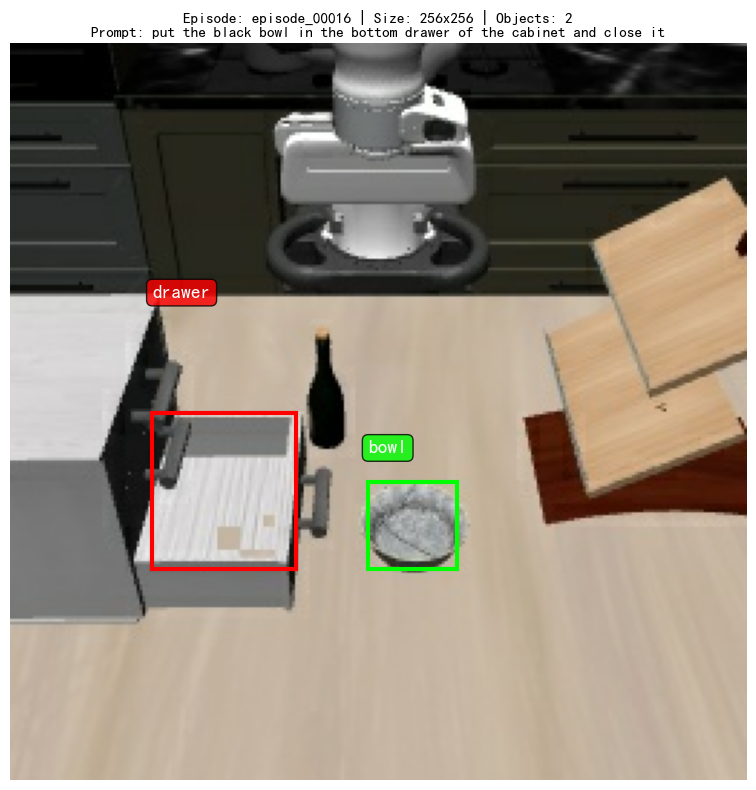

In [3]:
# Cell 3: 可视化单张图片函数（支持多bbox）

def normalize_bbox(bbox: list, img_width: int, img_height: int, coord_scale: int = 1000) -> list:
    """将归一化坐标（0-1000）转换为像素坐标"""
    x1, y1, x2, y2 = bbox
    return [
        int(x1 * img_width / coord_scale),
        int(y1 * img_height / coord_scale),
        int(x2 * img_width / coord_scale),
        int(y2 * img_height / coord_scale)
    ]

def visualize_single_bbox(
    item: Dict, 
    frame_idx: int = 0,
    figsize: tuple = (10, 8),
    bbox_colors: List[str] = ['lime', 'red', 'blue', 'orange', 'purple'],
    linewidth: int = 3,
    normalize_coords: bool = True,
    coord_scale: int = 1000
) -> None:
    """可视化单个检测结果（支持多bbox，兼容旧单bbox格式）"""
    # 转换路径（保持你的原有逻辑）
    episode_dir = convert_path(item['video_path'])
    frame_path = episode_dir / f"frame_{frame_idx:05d}.jpg"
    
    if not frame_path.exists():
        print(f"图像不存在: {frame_path}")
        return
    
    # 加载图像
    img = Image.open(frame_path)
    img_width, img_height = img.size
    
    # ========== 核心修改：适配多bbox字段 ==========
    # 兼容新格式（多bbox）和旧格式（单bbox）
    if 'bboxes_2d' in item['result'] and 'labels' in item['result']:
        bboxes = item['result']['bboxes_2d']
        labels = item['result']['labels']
    elif 'bbox_2d' in item['result'] and 'label' in item['result']:
        bboxes = [item['result']['bbox_2d']]
        labels = [item['result']['label']]
    else:
        print("错误：未找到有效的bbox数据")
        return
    
    # 验证数据长度一致性
    if len(labels) != len(bboxes):
        print(f"警告：labels和bboxes长度不匹配！")
        min_len = min(len(labels), len(bboxes))
        labels, bboxes = labels[:min_len], bboxes[:min_len]
    
    # 创建图形
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    
    # ========== 循环绘制多个bbox ==========
    for idx, (bbox, label) in enumerate(zip(bboxes, labels)):
        # 坐标转换
        bbox_pixel = normalize_bbox(bbox, img_width, img_height, coord_scale) if normalize_coords else bbox
        
        # 绘制边框（循环使用颜色）
        color = bbox_colors[idx % len(bbox_colors)]
        x1, y1, x2, y2 = bbox_pixel
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=linewidth, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        # 标签垂直偏移，避免重叠
        ax.text(
            x1, max(y1 - 10 - idx*30, 15),
            f"{label}",
            color='white', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8)
        )
    
    # 更新标题（显示检测到的物体数量）
    episode_name = Path(item['video_path']).name
    ax.set_title(
        f"Episode: {episode_name} | Size: {img_width}x{img_height} | Objects: {len(labels)}\nPrompt: {item['prompt']}",
        fontsize=11, wrap=True
    )
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# 测试：可视化第一条记录
print("可视化第一条检测结果:")
if 'bboxes_2d' in bbox_data[0]['result']:
    print(f"原始 bboxes (归一化坐标 0-1000): {bbox_data[0]['result']['bboxes_2d']}")
else:
    print(f"原始 bbox (归一化坐标 0-1000): {bbox_data[0]['result']['bbox_2d']}")
visualize_single_bbox(bbox_data[0])

批量可视化前 9 条检测结果 (支持多bbox):


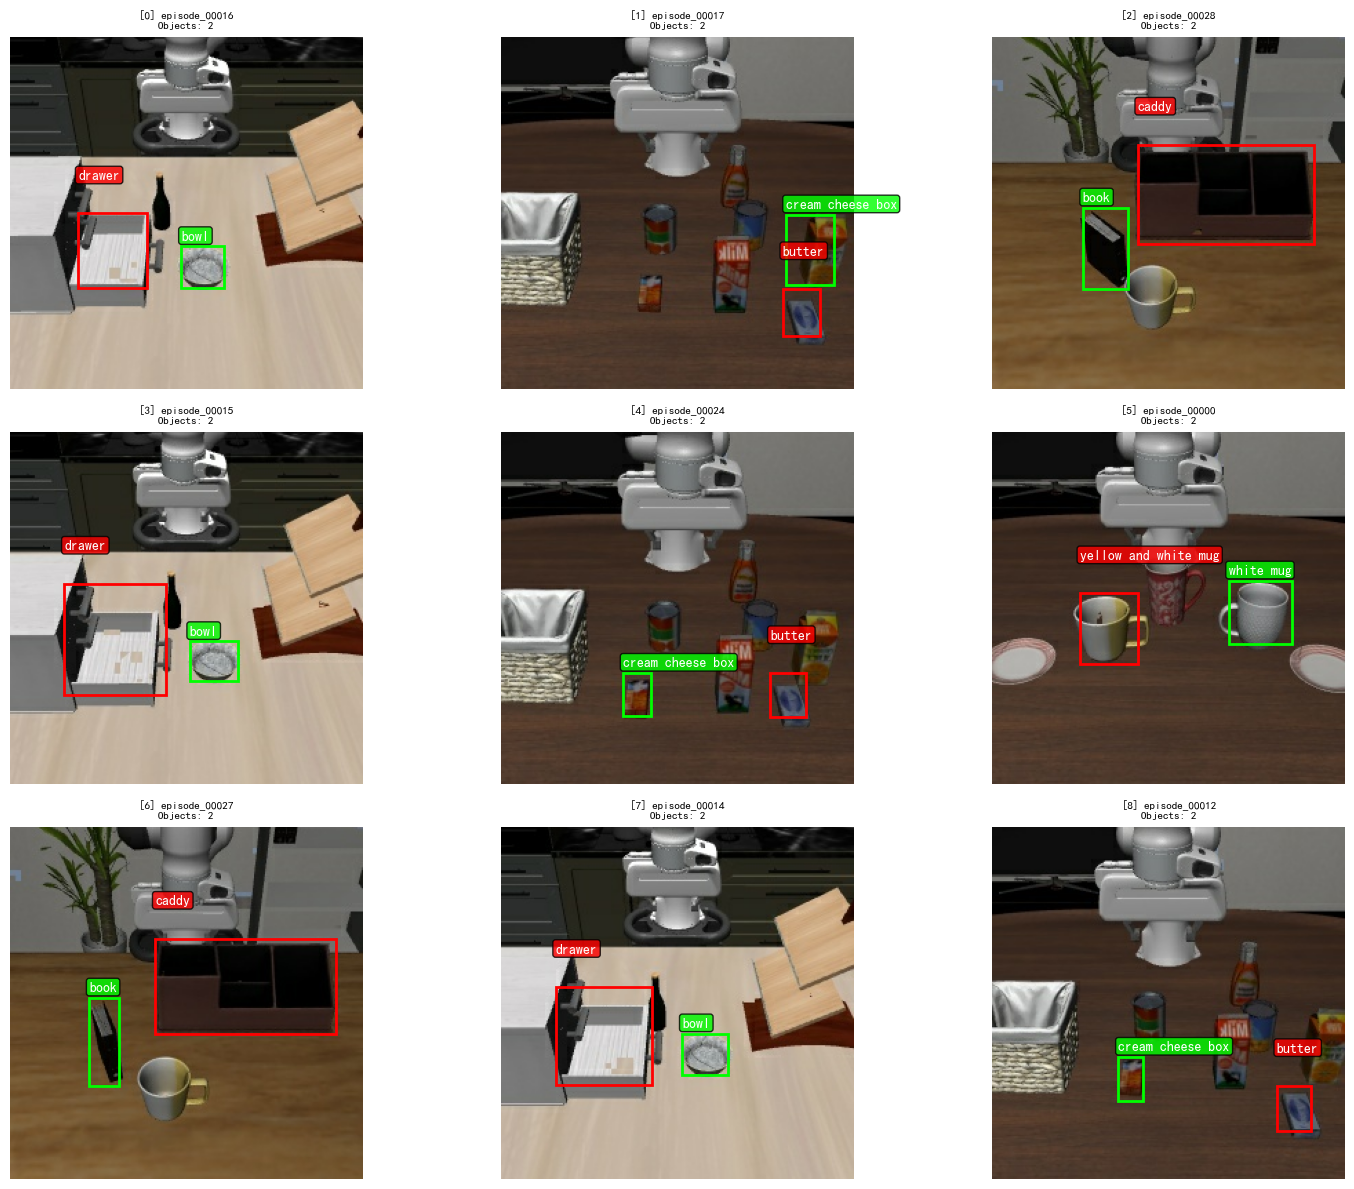

In [4]:
# Cell 4: 批量可视化（网格展示）- 支持多bbox

def visualize_batch_bbox(
    data: List[Dict],
    start_idx: int = 0,
    num_images: int = 9,
    cols: int = 3,
    frame_idx: int = 0,
    figsize_per_img: tuple = (5, 4),
    bbox_colors: List[str] = ['lime', 'red', 'blue', 'orange', 'purple'],
    normalize_coords: bool = True,
    coord_scale: int = 1000
) -> None:
    """
    批量可视化检测结果（网格布局，支持多bbox）
    
    Args:
        data: bbox 数据列表（支持labels/bboxes_2d数组）
        start_idx: 起始索引
        num_images: 显示图像数量
        cols: 列数
        frame_idx: 使用哪一帧图像
        figsize_per_img: 每张图的大小
        bbox_colors: bbox颜色列表（循环使用）
        normalize_coords: 是否转换归一化坐标 (0-1000)
        coord_scale: 归一化坐标范围
    """
    # 确定显示的数据范围
    end_idx = min(start_idx + num_images, len(data))
    items = data[start_idx:end_idx]
    actual_num = len(items)
    
    if actual_num == 0:
        print("没有数据可显示")
        return
    
    # 计算行数
    rows = (actual_num + cols - 1) // cols
    
    # 创建图形
    figsize = (figsize_per_img[0] * cols, figsize_per_img[1] * rows)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # 确保 axes 是二维数组
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, item in enumerate(items):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # 转换路径
        episode_dir = convert_path(item['video_path'])
        frame_path = episode_dir / f"frame_{frame_idx:05d}.jpg"
        
        if not frame_path.exists():
            ax.text(0.5, 0.5, f"图像不存在\n{frame_path.name}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            continue
        
        # 加载并显示图像
        img = Image.open(frame_path)
        img_width, img_height = img.size
        ax.imshow(img)
        
        # ========== 核心修改：适配多bbox ==========
        # 兼容新格式（多bbox）和旧格式（单bbox）
        if 'bboxes_2d' in item['result'] and 'labels' in item['result']:
            bboxes = item['result']['bboxes_2d']
            labels = item['result']['labels']
        elif 'bbox_2d' in item['result'] and 'label' in item['result']:
            bboxes = [item['result']['bbox_2d']]
            labels = [item['result']['label']]
        else:
            ax.text(0.5, 0.5, "无有效bbox数据", ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            continue
        
        # 验证数据长度一致性
        if len(labels) != len(bboxes):
            min_len = min(len(labels), len(bboxes))
            labels, bboxes = labels[:min_len], bboxes[:min_len]
        
        # 循环绘制多个bbox
        for bbox_idx, (bbox, label) in enumerate(zip(bboxes, labels)):
            # 坐标转换
            if normalize_coords:
                bbox_pixel = normalize_bbox(bbox, img_width, img_height, coord_scale)
            else:
                bbox_pixel = bbox
            
            # 绘制边框（循环使用颜色）
            color = bbox_colors[bbox_idx % len(bbox_colors)]
            x1, y1, x2, y2 = bbox_pixel
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # 添加标签（垂直偏移避免重叠）
            ax.text(
                x1, max(y1 - 5 - bbox_idx*20, 10),
                label,
                color='white',
                fontsize=10,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor=color, alpha=0.8)
            )
        
        # 设置标题（显示物体数量）
        episode_name = Path(item['video_path']).name
        ax.set_title(f"[{start_idx + idx}] {episode_name}\nObjects: {len(labels)}", fontsize=8)
        ax.axis('off')
    
    # 隐藏多余的子图
    for idx in range(actual_num, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# 显示前 9 张检测结果
print("批量可视化前 9 条检测结果 (支持多bbox):")
visualize_batch_bbox(bbox_data, start_idx=0, num_images=9, cols=3)

In [5]:
# Cell 5: 按标签筛选可视化（支持多标签数组）

def get_unique_labels(data: List[Dict]) -> List[str]:
    """获取所有唯一的标签（支持多labels数组）"""
    labels = set()
    for item in data:
        # 兼容新格式（labels数组）和旧格式（单个label）
        if 'labels' in item['result'] and isinstance(item['result']['labels'], list):
            for lbl in item['result']['labels']:
                labels.add(lbl.strip())  # 去除首尾空格，避免重复
        elif 'label' in item['result']:
            labels.add(item['result']['label'].strip())
    return sorted(list(labels))

def filter_by_label(data: List[Dict], target_label: str) -> List[Dict]:
    """
    按标签筛选数据（支持多labels数组）
    只要item的labels中包含目标标签，就会被筛选出来
    """
    filtered = []
    target_label = target_label.strip()  # 统一格式
    for item in data:
        # 兼容新格式（labels数组）
        if 'labels' in item['result'] and isinstance(item['result']['labels'], list):
            if target_label in [lbl.strip() for lbl in item['result']['labels']]:
                filtered.append(item)
        # 兼容旧格式（单个label）
        elif 'label' in item['result']:
            if item['result']['label'].strip() == target_label:
                filtered.append(item)
    return filtered

# 显示所有唯一标签及数量
unique_labels = get_unique_labels(bbox_data)
print(f"检测到 {len(unique_labels)} 种不同的标签:")
for i, label in enumerate(unique_labels):
    count = len(filter_by_label(bbox_data, label))
    print(f"  {i+1}. {label}: {count} 个")

# 示例：筛选并可视化某个标签的结果
# target_label = "cup"  # 替换为你想筛选的标签
# filtered_data = filter_by_label(bbox_data, target_label)
# print(f"\n筛选出标签为 '{target_label}' 的数据共 {len(filtered_data)} 条")
# if filtered_data:
#     visualize_batch_bbox(filtered_data, start_idx=0, num_images=6, cols=3)

检测到 23 种不同的标签:
  1. alphabet soup: 75 个
  2. black bowl: 2 个
  3. book: 38 个
  4. bowl: 30 个
  5. butter: 47 个
  6. caddy: 38 个
  7. chocolate pudding: 33 个
  8. cream cheese box: 89 个
  9. drawer: 32 个
  10. microwave: 33 个
  11. moka pot: 27 个
  12. moka_pot: 42 个
  13. mug: 29 个
  14. pan: 2 个
  15. plate: 17 个
  16. red mug: 1 个
  17. stove: 69 个
  18. tomato sauce: 33 个
  19. white mug: 72 个
  20. white_mug: 2 个
  21. yellow and white mug: 37 个
  22. yellow mug: 2 个
  23. yellow_mug: 2 个


筛选出 'moka pot' 标签的 27 条记录



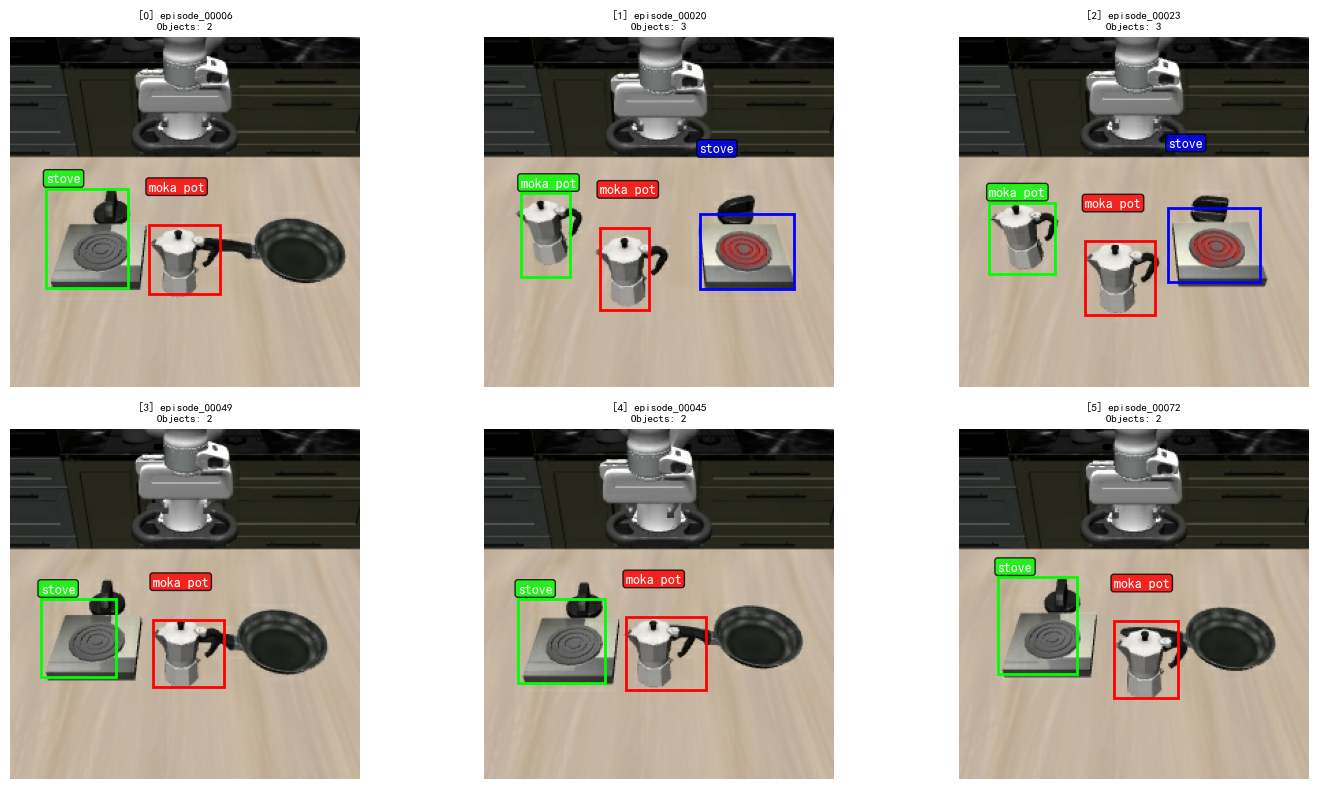

In [6]:
# Cell 6: 可视化特定标签的检测结果

# 选择要查看的标签（可以修改）
TARGET_LABEL = "moka pot"  # 修改此处查看不同标签

# 筛选数据
filtered_data = filter_by_label(bbox_data, TARGET_LABEL)
print(f"筛选出 '{TARGET_LABEL}' 标签的 {len(filtered_data)} 条记录\n")

# 可视化筛选结果
if filtered_data:
    visualize_batch_bbox(filtered_data, start_idx=0, num_images=6, cols=3)
else:
    print(f"没有找到标签为 '{TARGET_LABEL}' 的数据")


显示第 50 到 61 条检测结果:


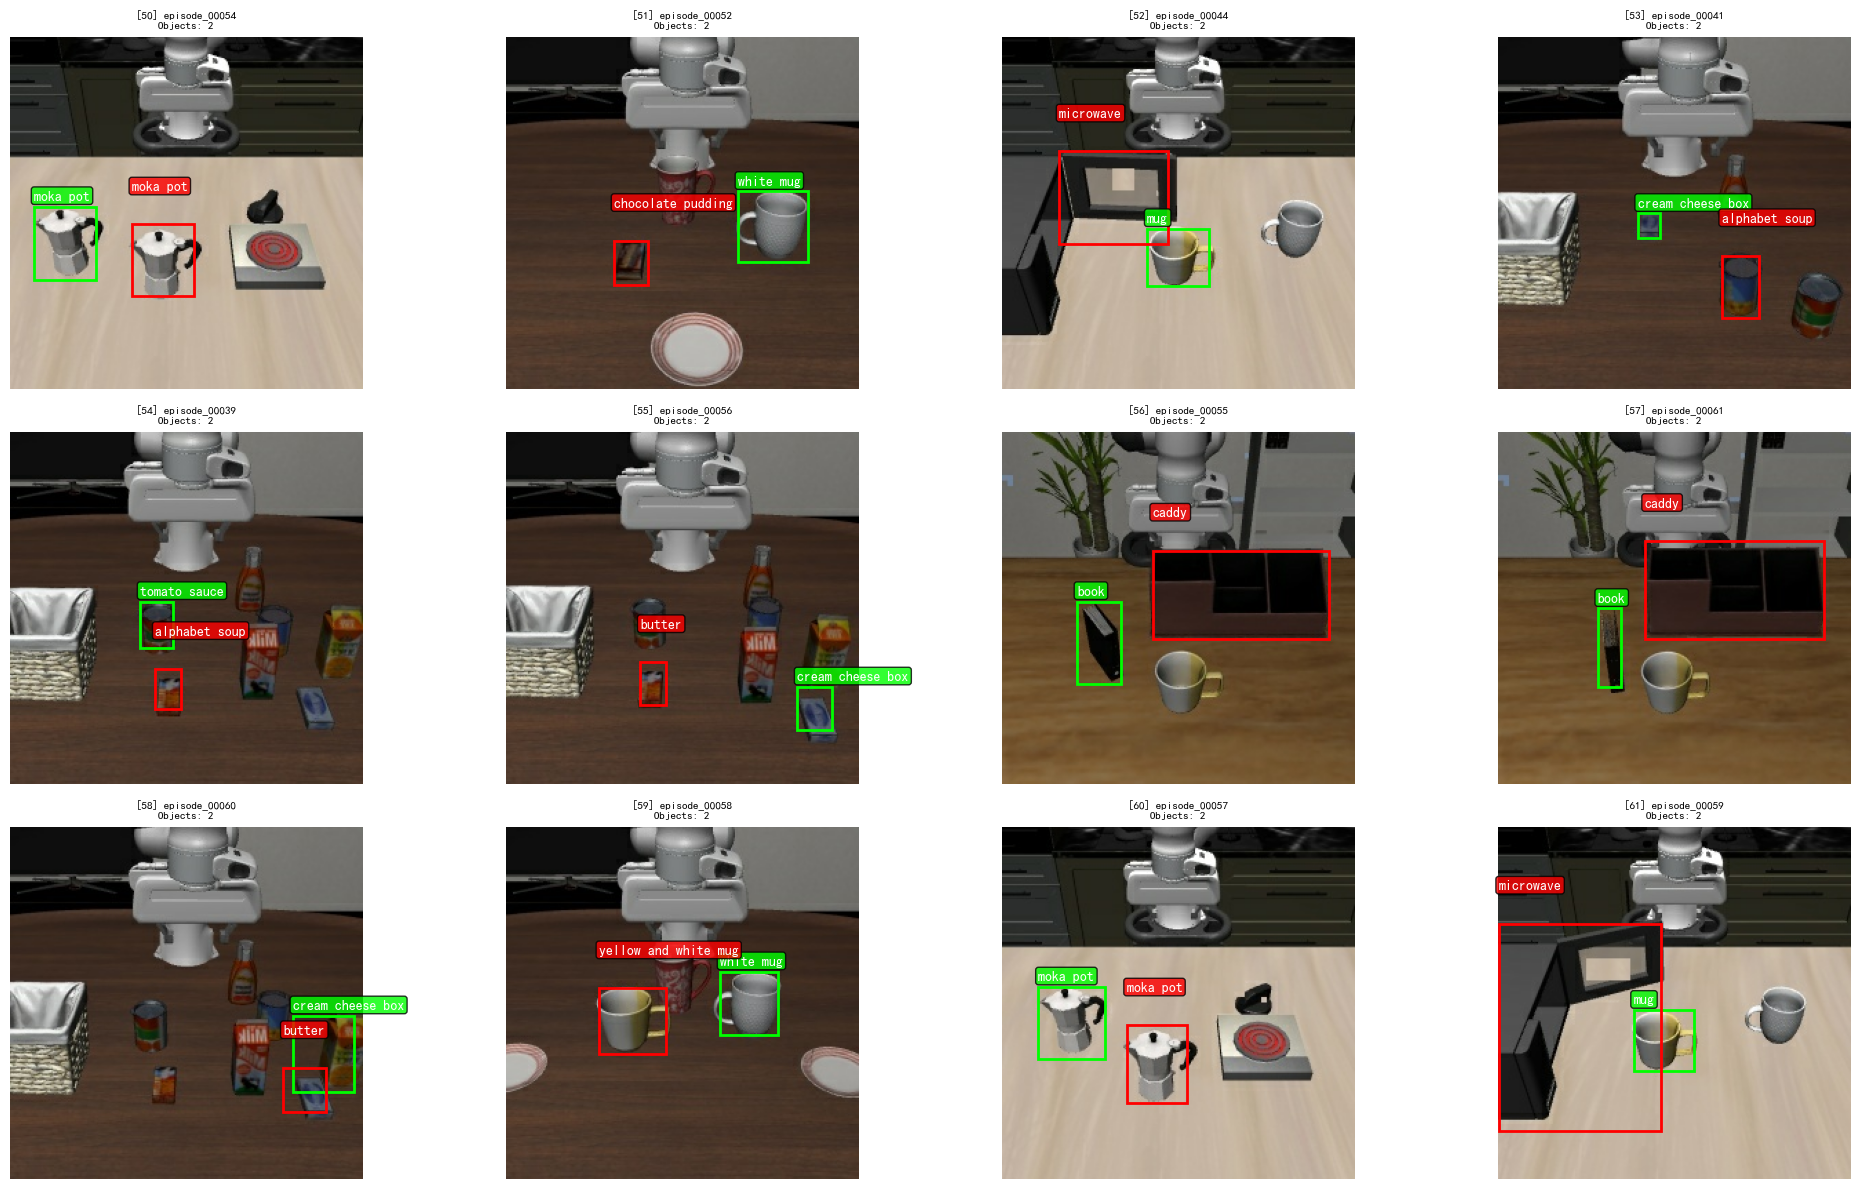

In [12]:
# Cell 7: 浏览更多数据（修改 start_idx 查看不同批次）

# 修改起始索引查看不同的数据
START_IDX = 50  # 从第 50 条开始
NUM_IMAGES = 12  # 显示 12 张

print(f"显示第 {START_IDX} 到 {START_IDX + NUM_IMAGES - 1} 条检测结果:")
visualize_batch_bbox(bbox_data, start_idx=START_IDX, num_images=NUM_IMAGES, cols=4)


In [16]:
# Cell 8: 保存带 bbox 的图像（可选）- 支持多bbox

from PIL import ImageDraw, ImageFont
from typing import Optional

def save_bbox_image(
    item: Dict,
    output_dir: Path,
    frame_idx: int = 0,
    bbox_colors: list = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 165, 0), (128, 0, 128)],  # 绿、红、蓝、橙、紫
    line_width: int = 3,
    normalize_coords: bool = True,
    coord_scale: int = 1000
) -> Optional[Path]:
    """
    将带有 bbox 的图像保存到指定目录（支持多bbox）
    
    Args:
        item: bbox 数据项（支持labels/bboxes_2d数组）
        output_dir: 输出目录
        frame_idx: 使用哪一帧
        bbox_colors: bbox 颜色列表 (R, G, B)，循环使用
        line_width: 线宽
        normalize_coords: 是否需要转换归一化坐标 (VLM 返回的是 0-1000 范围)
        coord_scale: 归一化坐标的范围 (默认 1000)
    
    Returns:
        保存的文件路径，失败返回 None
    """
    episode_dir = convert_path(item['video_path'])
    frame_path = episode_dir / f"frame_{frame_idx:05d}.jpg"
    
    if not frame_path.exists():
        return None
    
    # 加载图像
    img = Image.open(frame_path).convert('RGB')
    img_width, img_height = img.size
    draw = ImageDraw.Draw(img)
    
    # ========== 核心修改：适配多bbox ==========
    # 兼容新格式（多bbox）和旧格式（单bbox）
    if 'bboxes_2d' in item['result'] and 'labels' in item['result']:
        bboxes = item['result']['bboxes_2d']
        labels = item['result']['labels']
    elif 'bbox_2d' in item['result'] and 'label' in item['result']:
        bboxes = [item['result']['bbox_2d']]
        labels = [item['result']['label']]
    else:
        return None
    
    # 验证数据长度一致性
    if len(labels) != len(bboxes):
        min_len = min(len(labels), len(bboxes))
        labels, bboxes = labels[:min_len], bboxes[:min_len]
    
    # 循环绘制多个bbox
    for bbox_idx, (bbox, label) in enumerate(zip(bboxes, labels)):
        # 坐标转换：VLM 返回的是归一化到 0-1000 的坐标
        if normalize_coords:
            bbox_pixel = normalize_bbox(bbox, img_width, img_height, coord_scale)
        else:
            bbox_pixel = bbox
        
        x1, y1, x2, y2 = bbox_pixel
        # 选择颜色（循环使用颜色列表）
        color = bbox_colors[bbox_idx % len(bbox_colors)]
        
        # 绘制矩形框
        draw.rectangle([x1, y1, x2, y2], outline=color, width=line_width)
        
        # 绘制标签背景和文字（垂直偏移避免重叠）
        try:
            font = ImageFont.truetype("arial.ttf", 16)
        except:
            font = ImageFont.load_default()
        
        # 标签位置：每个bbox的标签垂直偏移25像素
        label_y = max(y1 - 20 - bbox_idx*25, 5)
        text_bbox = draw.textbbox((x1, label_y), label, font=font)
        draw.rectangle(text_bbox, fill=color)
        draw.text((x1, label_y), label, fill='white', font=font)
    
    # 保存
    output_dir.mkdir(parents=True, exist_ok=True)
    episode_name = Path(item['video_path']).stem  # 去掉扩展名，避免重复.jpg
    output_path = output_dir / f"{episode_name}_bbox.jpg"
    img.save(output_path, quality=95)
    
    return output_path

# 示例：保存前 5 个检测结果
OUTPUT_DIR = Path(LOCAL_PREFIX) / "data_processed" / "bbox_visualization"

print(f"保存带 bbox 的图像到: {OUTPUT_DIR}\n")
success_count = 0
for i, item in enumerate(bbox_data[:5]):
    save_path = save_bbox_image(item, OUTPUT_DIR)
    if save_path:
        print(f"  已保存: {save_path.name}")
        success_count += 1
    else:
        print(f"  保存失败: {Path(item['video_path']).name}")

print(f"\n共成功保存 {success_count}/5 张图像")

保存带 bbox 的图像到: d:\files\VLA-Adapter\data_processed\bbox_visualization

  已保存: episode_00004_bbox.jpg
  已保存: episode_00020_bbox.jpg
  已保存: episode_00011_bbox.jpg
  已保存: episode_00017_bbox.jpg
  已保存: episode_00010_bbox.jpg

共成功保存 5/5 张图像
